# Predicción de Enfermedades Considerando Sesgos

**Objetivo:**  
En este notebook, construiremos y evaluaremos un modelo de clasificación para predecir la presencia de diabetes en pacientes. Además, analizaremos el rendimiento del modelo en diferentes subgrupos demográficos para identificar posibles sesgos y desigualdades en las predicciones.

**Requisitos previos:**  
No se asume experiencia previa en programación. Se proporcionarán explicaciones detalladas y comentarios en el código.

## Contenido

1. [Importar Librerías Necesarias](#1)
2. [Cargar y Explorar el Conjunto de Datos](#2)
3. [Preprocesamiento de Datos](#3)
4. [Dividir Datos en Entrenamiento y Prueba](#4)
5. [Entrenamiento del Modelo de Regresión Logística](#5)
6. [Evaluación del Modelo - Métricas Globales](#6)
7. [Análisis del Rendimiento por Subgrupos Demográficos](#7)
8. [Consideraciones sobre Sesgos y Equidad](#8)
9. [Conclusiones y Próximos Pasos](#9)
10. [Recursos Adicionales](#10)

## 1. Importar Librerías Necesarias <a name="1"></a>

Importaremos las librerías que utilizaremos para nuestro análisis:

- `pandas` para manipulación de datos.
- `numpy` para operaciones numéricas.
- `matplotlib` y `seaborn` para visualización de datos.
- `scikit-learn` para modelado y evaluación.

In [ ]:
# Instalación de paquetes necesarios (ejecutar si es necesario)
!pip install pandas numpy matplotlib seaborn scikit-learn

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para el modelado
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)

# Configurar estilos de los gráficos
%matplotlib inline
sns.set(style="whitegrid")

## 2. Cargar y Explorar el Conjunto de Datos <a name="2"></a>

Utilizaremos el conjunto de datos **"Diabetes de Pima Indians"** disponible públicamente. Este dataset contiene información médica de pacientes y si tienen o no diabetes.

**Descripción del Conjunto de Datos:**

- **Pregnancies**: Número de veces embarazada.
- **Glucose**: Concentración de glucosa plasmática a 2 horas en una prueba oral de tolerancia a la glucosa.
- **BloodPressure**: Presión arterial diastólica (mm Hg).
- **SkinThickness**: Espesor del pliegue cutáneo del tríceps (mm).
- **Insulin**: Insulina sérica de 2 horas (mu U/ml).
- **BMI**: Índice de masa corporal (peso en kg / (estatura en m)^2).
- **DiabetesPedigreeFunction**: Función de pedigrí de diabetes.
- **Age**: Edad (años).
- **Outcome**: Variable de clase (0 si no tiene diabetes, 1 si tiene diabetes).

In [2]:
# Cargar el conjunto de datos desde una URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columnas = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
data = pd.read_csv(url, names=columnas)

# Mostrar las primeras filas del conjunto de datos
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 3. Preprocesamiento de Datos <a name="3"></a>

### 3.1. Verificar Valores Nulos o Ceros

Algunas variables tienen valores de cero que no son posibles (por ejemplo, presión arterial cero). Reemplazaremos estos ceros por valores `NaN` para poder tratarlos adecuadamente.

In [3]:
# Lista de columnas que no pueden tener cero
vars_no_cero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Reemplazar ceros por NaN
for col in vars_no_cero:
    data[col] = data[col].replace(0, np.nan)

# Mostrar conteo de valores nulos
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### 3.2. Imputación de Valores Faltantes

Para simplificar, imputaremos los valores faltantes utilizando la mediana de cada variable.

In [4]:
# Imputar valores faltantes con la mediana
for col in vars_no_cero:
    data[col].fillna(data[col].median(), inplace=True)

# Verificar que no hay valores nulos
data.isnull().sum()

C:\Users\jgibert\AppData\Local\Temp\ipykernel_25128\4094743159.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 4. Dividir Datos en Entrenamiento y Prueba <a name="4"></a>

Dividiremos el conjunto de datos en un 80% para entrenamiento y un 20% para prueba.

In [5]:
# Separar variables independientes y dependiente
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 5. Entrenamiento del Modelo de Regresión Logística <a name="5"></a>

Entrenaremos un modelo de regresión logística utilizando los datos de entrenamiento.

In [6]:
# Crear el modelo
model = LogisticRegression(max_iter=1000)

# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## 6. Evaluación del Modelo - Métricas Globales <a name="6"></a>

### 6.1. Predicciones en el Conjunto de Prueba

In [7]:
# Realizar predicciones
y_pred = model.predict(X_test)

### 6.2. Métricas de Evaluación

#### 6.2.1. Matriz de Confusión

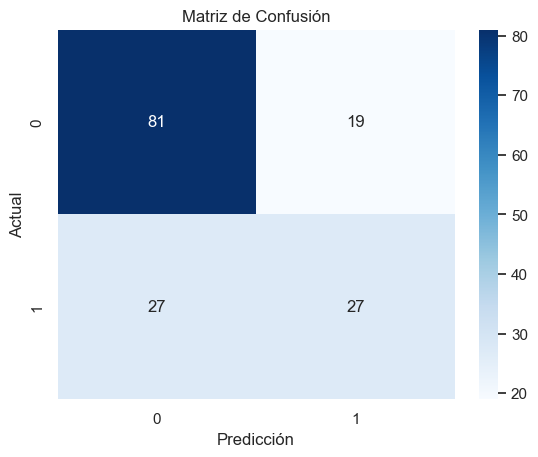

In [8]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

#### 6.2.2. Informe de Clasificación

In [9]:
# Informe de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



#### 6.2.3. Curva ROC y AUC

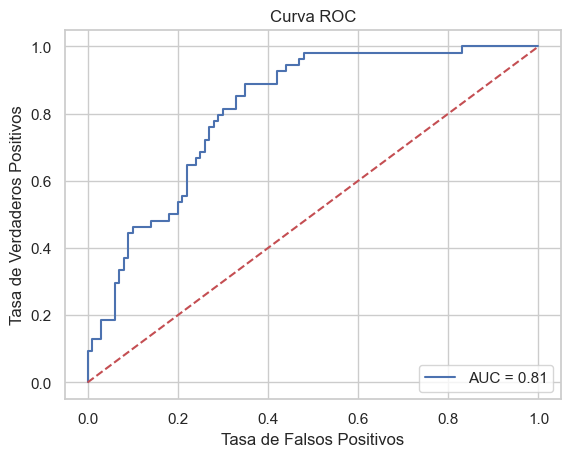

In [10]:
# Probabilidades de predicción
y_pred_proba = model.predict_proba(X_test)[::,1]

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

## 7. Análisis del Rendimiento por Subgrupos Demográficos <a name="7"></a>

Analizaremos el rendimiento del modelo en diferentes grupos de edad para identificar posibles sesgos.

### 7.1. Crear Categorías de Edad

Dividiremos la edad en grupos:

- **Joven**: Menos de 30 años
- **Adulto**: Entre 30 y 50 años
- **Mayor**: Más de 50 años

In [11]:
# Crear categorías de edad en el conjunto original
def categorizar_edad(age):
    if age < 30:
        return 'Joven'
    elif age <= 50:
        return 'Adulto'
    else:
        return 'Mayor'

data['AgeGroup'] = data['Age'].apply(categorizar_edad)

### 7.2. Análisis del Rendimiento por Grupo de Edad

#### 7.2.1. Añadir Grupos de Edad a los Conjuntos de Prueba

Como usamos `train_test_split`, necesitamos extraer los grupos de edad correspondientes al conjunto de prueba.

In [12]:
# Resetear índices
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Añadir AgeGroup al conjunto de prueba
X_test['AgeGroup'] = data.loc[X_test.index, 'AgeGroup']

#### 7.2.2. Evaluar Métricas por Grupo

Calcularemos la precisión del modelo para cada grupo de edad.

In [13]:
# Evaluar precisión por grupo de edad
age_groups = X_test['AgeGroup'].unique()
for group in age_groups:
    idx = X_test[X_test['AgeGroup'] == group].index
    y_true_group = y_test[idx]
    y_pred_group = y_pred[idx]
    accuracy = accuracy_score(y_true_group, y_pred_group)
    print(f'Precisión para el grupo {group}: {accuracy:.2f}')

Precisión para el grupo Adulto: 0.78
Precisión para el grupo Joven: 0.68
Precisión para el grupo Mayor: 0.50


### 7.3. Visualizar Resultados

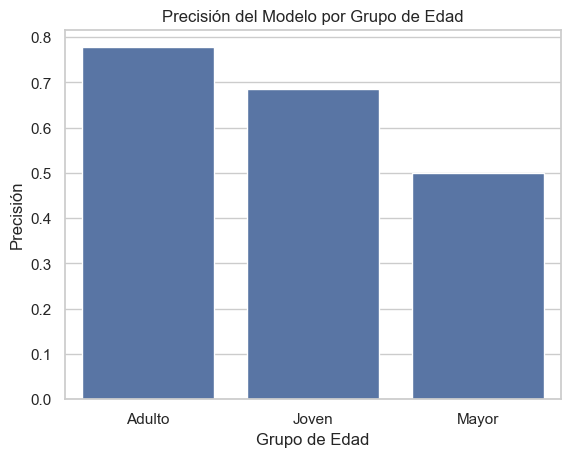

In [14]:
# Crear un DataFrame con resultados
results = []
for group in age_groups:
    idx = X_test[X_test['AgeGroup'] == group].index
    y_true_group = y_test[idx]
    y_pred_group = y_pred[idx]
    accuracy = accuracy_score(y_true_group, y_pred_group)
    results.append({'AgeGroup': group, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)

# Graficar precisión por grupo de edad
sns.barplot(x='AgeGroup', y='Accuracy', data=results_df)
plt.title('Precisión del Modelo por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Precisión')
plt.show()

## 8. Consideraciones sobre Sesgos y Equidad <a name="8"></a>

Analizando los resultados, podemos observar si el modelo tiene un rendimiento inferior en algún grupo de edad, lo que podría indicar un sesgo.

**Posibles causas:**

- **Distribución de datos desigual:** Si un grupo está subrepresentado en los datos de entrenamiento, el modelo puede no aprender patrones relevantes para ese grupo.
- **Diferencias en las características:** Las variables predictoras pueden relacionarse de manera diferente con el resultado en distintos grupos.

**Acciones a Tomar:**

- **Balancear los datos:** Asegurar que cada grupo esté adecuadamente representado.
- **Modelos específicos por grupo:** Entrenar modelos separados o incluir interacciones en el modelo.
- **Análisis más profundo:** Investigar qué variables afectan el rendimiento en cada grupo.

## 9. Conclusiones y Próximos Pasos <a name="9"></a>

- **Importancia de Evaluar por Subgrupos:**
  - Identificar sesgos ayuda a mejorar la equidad y eficacia de los modelos en contextos clínicos.
- **Mejoras Potenciales:**
  - Incluir más variables demográficas (género, etnia) si están disponibles.
  - Utilizar técnicas avanzadas para mitigación de sesgos, como reponderación o ajustes en la función de pérdida.

**Próximos Pasos:**

- **Profundizar en el Análisis:**
  - Realizar análisis similares para otros subgrupos.
- **Experimentar con Otros Modelos:**
  - Probar modelos más complejos como árboles de decisión o redes neuronales.
- **Validación Cruzada:**
  - Utilizar validación cruzada para obtener estimaciones más robustas del rendimiento del modelo.

## 10. Recursos Adicionales <a name="10"></a>

- **Documentación de Scikit-learn:** [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)
- **Introducción a la Regresión Logística:** [Artículo en Wikipedia](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica)
- **Guía sobre Equidad y Sesgos en IA:** [Fairness in Machine Learning](https://fairmlbook.org/)